In [318]:
import torch
import torch.nn as nn
import torchaudio

In [467]:
class SpecModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels):
    super().__init__()
    self.mel_converter = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, center=False)
    self.db_converter = torchaudio.transforms.AmplitudeToDB()
  
  def forward(self, x):
    mel_spec = self.mel_converter(x)
    return self.db_converter(mel_spec)

class AudioModel(nn.Module):
  def __init__(self, sr, n_fft, hop_length, n_mels, hidden_size, num_output):
    super().__init__()
    self.sr = sr
    self.spec_converter = SpecModel(sr, n_fft, hop_length, n_mels)
    self.spec_norm = nn.BatchNorm1d(n_mels)
    self.conv_layer = nn.Sequential(
      nn.Conv1d(n_mels, out_channels=hidden_size//8, kernel_size=3),
      nn.BatchNorm1d(hidden_size//8),
      nn.MaxPool1d(2),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.BatchNorm1d(hidden_size),
      nn.MaxPool1d(2),
      nn.ReLU(),     
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.BatchNorm1d(hidden_size),
      nn.MaxPool1d(2),
      nn.ReLU(),
      nn.Conv1d(hidden_size, out_channels=hidden_size, kernel_size=3),
      nn.BatchNorm1d(hidden_size),
      nn.ReLU(),
    )
    self.final_layer = nn.Linear(hidden_size, num_output)

  def get_spec(self, x):
    '''
    Get result of self.spec_converter
    x (torch.Tensor): audio samples (num_batch_size X num_audio_samples)
    '''
    return self.spec_converter(x)
  
  def get_without_final_pooling(self, x, input_is_spec=False):
    if not input_is_spec:
      x = self.get_spec(x) # num_batch X num_mel_bins X num_time_bins
    spec = self.spec_norm(x)
    out = self.conv_layer(spec)
    out = self.final_layer(out.permute(0,2,1))
    out = torch.sigmoid(out)
    return out
  
  def forward(self, x):
    spec = self.get_spec(x) # num_batch X num_mel_bins X num_time_bins
    spec = self.spec_norm(spec)
    out = self.conv_layer(spec)
    out = self.final_layer(out.permute(0,2,1))
    out = torch.max(out, dim=1)[0]
    out = torch.sigmoid(out)
    return out
  
model = AudioModel(sr=16000, n_fft=1024, hop_length=512, n_mels=128, num_output=100, hidden_size=1024)


In [468]:
saved_file_path = 'audioset_model_maxpool_later_epoch100.pt'
saved_dict = torch.load(saved_file_path)
model.load_state_dict(saved_dict['state'])

RuntimeError: Error(s) in loading state_dict for AudioModel:
	size mismatch for conv_layer.0.weight: copying a param with shape torch.Size([128, 128, 3]) from checkpoint, the shape in current model is torch.Size([1024, 128, 3]).
	size mismatch for conv_layer.0.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.4.weight: copying a param with shape torch.Size([256, 128, 3]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 3]).
	size mismatch for conv_layer.4.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.5.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.5.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.5.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.5.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.8.weight: copying a param with shape torch.Size([512, 256, 3]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 3]).
	size mismatch for conv_layer.8.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.9.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.9.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.9.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.9.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for conv_layer.12.weight: copying a param with shape torch.Size([1024, 512, 3]) from checkpoint, the shape in current model is torch.Size([1024, 1024, 3]).

In [321]:
y, sr = torchaudio.load('AudioSet/--PJHxphWEs_30.0.wav')
y = y.mean(dim=0).unsqueeze(0)
ipd.Audio(y, rate=sr)

In [324]:
y[0].shape

torch.Size([160000])

In [328]:
model(y)

tensor([[3.3720e-02, 9.9439e-01, 1.9871e-02, 6.2722e-04, 3.2889e-04, 4.7239e-05,
         1.8060e-05, 9.1652e-06, 1.1644e-05, 4.5624e-06, 5.0174e-03, 2.6453e-05,
         1.4011e-07, 1.0425e-06, 3.1899e-03, 5.4586e-05, 1.5891e-02, 2.2812e-04,
         1.6467e-05, 2.7534e-04]], grad_fn=<SigmoidBackward0>)

In [329]:
spec = model.spec_converter(y)

In [330]:
spec.shape

torch.Size([1, 96, 311])

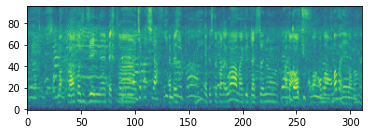

In [333]:
plt.imshow(spec[0], origin='lower')

In [334]:
norm_spec = model.spec_norm(spec)

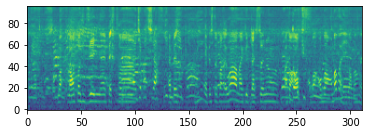

In [336]:
plt.imshow(norm_spec[0].detach(), origin='lower')

In [338]:
conv_out = model.conv_layer(norm_spec)
# out = self.final_layer(out.permute(0,2,1))
# out = torch.sigmoid(out)

In [340]:
conv_out.shape

torch.Size([1, 128, 35])

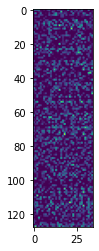

In [341]:
plt.imshow(conv_out[0].detach())

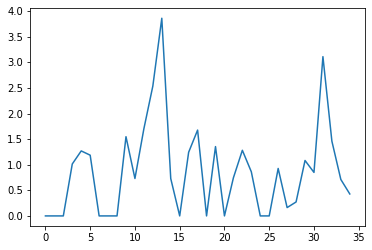

In [346]:
plt.plot(conv_out[0,3,:].detach())

In [348]:
model.final_layer

Linear(in_features=128, out_features=20, bias=True)

In [349]:
conv_out.shape # Batch X Channel X Time Step

torch.Size([1, 128, 35])

In [351]:
conv_out.permute(0,2,1).shape

torch.Size([1, 35, 128])

In [353]:
final_out = model.final_layer(conv_out.permute(0,2,1))

In [355]:
probability = torch.sigmoid(final_out)

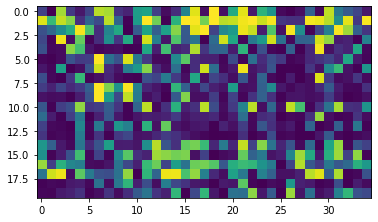

In [357]:
plt.imshow(probability.detach()[0].T)

In [359]:
ipd.Audio(y, rate=sr)

In [358]:
model.vocab

array(['Music', 'Speech', 'Vehicle', 'Inside, small room', 'Animal',
       'Musical instrument', 'Singing', 'Domestic animals, pets',
       'Guitar', 'Plucked string instrument', 'Car', 'Dog', 'Percussion',
       'Wind instrument, woodwind instrument',
       'Outside, urban or manmade', 'Boat, Water vehicle',
       'Outside, rural or natural', 'Water', 'Brass instrument', 'Siren'],
      dtype='<U36')

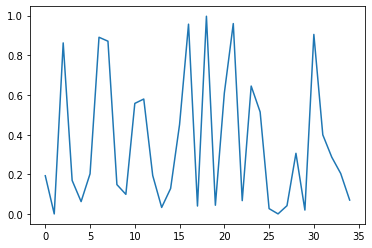

In [422]:
plt.plot(prob[0,:,0].detach())

In [ ]:
musicality = 

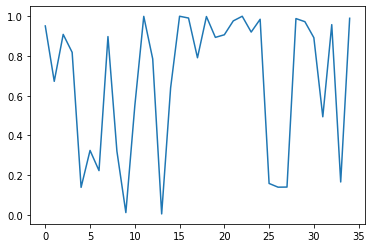

In [360]:
plt.plot(probability.detach()[0,:,1])

In [363]:
prob=probability
prob.shape # batch X time frame X tag 

torch.Size([1, 35, 20])

In [366]:
prob[0,11,1].backward()

In [368]:
model.final_layer.weight.grad

tensor([[3.8536e+00, 1.9662e-01, 1.6616e-01,  ..., 3.3308e+00, 2.6283e-01,
         2.1780e-01],
        [0.0000e+00, 1.0140e-03, 0.0000e+00,  ..., 0.0000e+00, 1.4253e-03,
         1.0320e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [371]:
y.requires_grad

False

In [419]:
y, sr = torchaudio.load('AudioSet/--PJHxphWEs_30.0.wav')
y = y.mean(dim=0).unsqueeze(0)
y.requires_grad = True
model = AudioModel(sr=16000, n_fft=1024, hop_length=512, n_mels=96, num_output=20, hidden_size=128)
model.eval()
saved_file_path = 'audioset_model.pt'
saved_dict = torch.load(saved_file_path)
model.load_state_dict(saved_dict['state'])

prob = model.get_without_final_pooling(y)
prob[0,11,1].backward()
start, end = torch.min(torch.where(y.grad !=0)[1]), torch.max(torch.where(y.grad !=0)[1])
print(start, end)

tensor(45057) tensor(65023)


In [421]:
ipd.Audio(y[:,45057:65024].detach(), rate=sr)

In [416]:
(end-start+2-1024) / 512  + 1

tensor(38.)

In [415]:
next(model.spec_converter.buffers())

tensor([0.0000e+00, 9.4175e-06, 3.7640e-05,  ..., 8.4698e-05, 3.7640e-05,
        9.4175e-06])

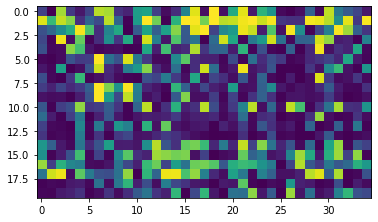

In [418]:
plt.imshow(prob[0].detach().T)

In [425]:
musicality = prob[:,:,0].mean()
musicality

tensor(0.3583, grad_fn=<MeanBackward0>)

In [459]:
y, sr = torchaudio.load('AudioSet/--PJHxphWEs_30.0.wav')
y = y.mean(dim=0).unsqueeze(0)
y.requires_grad = True
model = AudioModel(sr=16000, n_fft=1024, hop_length=512, n_mels=96, num_output=20, hidden_size=128)
model.eval()
saved_file_path = 'audioset_model.pt'
saved_dict = torch.load(saved_file_path)
model.load_state_dict(saved_dict['state'])

for param in model.parameters():
  param.requires_grad = False

sample_optimizer = torch.optim.SGD([y], lr=0.05)

for i in range(100):
  prob = model.get_without_final_pooling(y)
  musicality = prob[:,:,0].mean()
  loss = -musicality
  loss.backward()
  sample_optimizer.step()
  sample_optimizer.zero_grad()
  print(y[0,10000:10010])

tensor([-0.0644, -0.0151,  0.1020,  0.0820,  0.0899,  0.1001,  0.1270,  0.0956,
         0.0412,  0.1423], grad_fn=<SliceBackward0>)
tensor([-0.0642, -0.0149,  0.1023,  0.0822,  0.0902,  0.1004,  0.1274,  0.0959,
         0.0415,  0.1426], grad_fn=<SliceBackward0>)
tensor([-0.0643, -0.0149,  0.1023,  0.0823,  0.0902,  0.1004,  0.1275,  0.0959,
         0.0415,  0.1426], grad_fn=<SliceBackward0>)
tensor([-0.0642, -0.0148,  0.1024,  0.0825,  0.0904,  0.1006,  0.1277,  0.0961,
         0.0417,  0.1428], grad_fn=<SliceBackward0>)
tensor([-0.0642, -0.0149,  0.1024,  0.0825,  0.0904,  0.1006,  0.1277,  0.0961,
         0.0417,  0.1428], grad_fn=<SliceBackward0>)
tensor([-0.0642, -0.0148,  0.1025,  0.0825,  0.0905,  0.1007,  0.1278,  0.0961,
         0.0417,  0.1428], grad_fn=<SliceBackward0>)
tensor([-0.0641, -0.0148,  0.1026,  0.0826,  0.0906,  0.1008,  0.1279,  0.0963,
         0.0418,  0.1429], grad_fn=<SliceBackward0>)
tensor([-0.0641, -0.0148,  0.1026,  0.0826,  0.0906,  0.1008,  0.1279

tensor([-0.0641, -0.0150,  0.1029,  0.0832,  0.0911,  0.1014,  0.1290,  0.0975,
         0.0429,  0.1431], grad_fn=<SliceBackward0>)
tensor([-0.0641, -0.0150,  0.1029,  0.0832,  0.0911,  0.1014,  0.1291,  0.0975,
         0.0429,  0.1431], grad_fn=<SliceBackward0>)
tensor([-0.0641, -0.0150,  0.1029,  0.0832,  0.0911,  0.1014,  0.1291,  0.0975,
         0.0429,  0.1431], grad_fn=<SliceBackward0>)
tensor([-0.0641, -0.0150,  0.1029,  0.0832,  0.0911,  0.1014,  0.1291,  0.0975,
         0.0429,  0.1431], grad_fn=<SliceBackward0>)


In [460]:
prob = model.get_without_final_pooling(y)
prob[0,:,0]

tensor([0.9967, 0.9951, 0.9954, 0.9910, 0.9930, 0.9959, 0.9970, 0.9963, 0.9897,
        0.9956, 0.9951, 0.9963, 0.9942, 0.9940, 0.9939, 0.9938, 0.9975, 0.9970,
        0.9989, 0.9971, 0.9949, 0.9961, 0.9958, 0.9969, 0.9972, 0.9974, 0.0011,
        0.9967, 0.9939, 0.9924, 0.9970, 0.9934, 0.9984, 0.9955, 0.9948],
       grad_fn=<SelectBackward0>)

In [461]:
y_modified = torch.clone(y)
ipd.Audio(y_modified.detach(), rate=sr)

In [462]:
y, sr = torchaudio.load('AudioSet/--PJHxphWEs_30.0.wav')
y = y.mean(dim=0).unsqueeze(0)
ipd.Audio(y.detach(), rate=sr)

In [463]:
diff = torch.abs(y_modified-y)
torch.mean(diff)

tensor(0.0014, grad_fn=<MeanBackward0>)

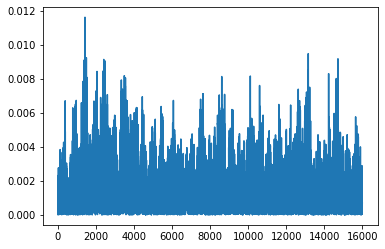

In [458]:
plt.plot(diff[0, 16000:32000].detach())

In [403]:
y.grad

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [396]:
prob.shape

torch.Size([1, 35, 20])

In [404]:
torch.where(y.grad !=0)[1]

tensor([45057, 45058, 45059,  ..., 65021, 65022, 65023])

In [16]:
for buffer in model.spec_converter.buffers():
  buffer.requires_grad = True

In [18]:
for param in model.spec_converter.named_parameters():
  print(param)

In [33]:
y, sr = torchaudio.load('AudioSet/--PJHxphWEs_30.0.wav')
y.requires_grad=True

In [34]:
model.eval()
out = model.get_without_final_pooling(y.mean(dim=0).unsqueeze(0))

In [29]:
out.shape

torch.Size([1, 35, 20])

In [35]:
out[0,0,0].backward()

In [317]:
y, sr = torchaudio.load('AudioSet/--PJHxphWEs_30.0.wav')
y = y.mean(dim=0).unsqueeze(0)
y.requires_grad=True
model.eval()
out = model.get_without_final_pooling(y)
out[0,0,0].backward()

start, end = torch.max(torch.where(y.grad!=0)[1]), torch.min(torch.where(y.grad!=0)[1])
print(start, end)
print( (start-end+2-1024)/512+1)

tensor(19967) tensor(1)
tensor(38.)
